## Training with a Neural Network
This notebook contains the training of a Keras Sequential model on insider data, which attempts to predict the maximum 90-day percentage gain of a ticker whose insider(s) made a trade. We use a single dense hidden layer and a dropout layer, and we use the Keras Tuner to choose an optimal learning rate and number of hidden units.

In [104]:
%load_ext autoreload
%autoreload 1
%aimport my_functions

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.activations import linear
from tensorflow.keras.regularizers import L2
from operator import itemgetter

from my_functions import *

pd.options.mode.chained_assignment = None
plt.style.use('fivethirtyeight')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
DAYS_TO_LOOK_BACK = 6  # used for calculating volume volatility and recent-trade counts

train_and_cv = my_model_prep.prepareForModel(pd.read_csv('data/training_and_cv_data.csv'))

startDate = min(train_and_cv.FilingDate) + dt.timedelta(days=DAYS_TO_LOOK_BACK)
endDate = max(train_and_cv.FilingDate)
splitDate = startDate + dt.timedelta(days=int(0.95*(endDate-startDate).days))

train_XY, train_X, train_Y = my_model_prep.returnXandY(
    train_and_cv, dt.date.isoformat(startDate), dt.date.isoformat(splitDate), binStarts=[-10, 0, 20]
)

cv_XY, cv_X, cv_Y = my_model_prep.returnXandY(
    train_and_cv, dt.date.isoformat(splitDate+dt.timedelta(days=1)), dt.date.isoformat(endDate)
)

In [169]:
print(f'Training begins on {startDate} and ends on {splitDate}')
print(f'CV begins on {splitDate+dt.timedelta(days=1)} and ends on {endDate}')
print(f'Train shape: {train_X.shape}')
print(f'CV shape: {cv_X.shape}')

Training begins on 2021-06-07 and ends on 2021-08-26
CV begins on 2021-08-27 and ends on 2021-08-31
Train shape: (23349, 10)
CV shape: (656, 10)


In [146]:
'''
Perform standard feature normalization.
'''
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
cv_X_scaled = scaler.fit_transform(cv_X)

Here is a StackExchange answer that provides a starting point for deciding on the number of hidden units to include: https://stats.stackexchange.com/a/136542

### Below is a computation to obtain the absolute maximum number of hidden units:

In [147]:
Ns = train_X_scaled.shape[0]  # training examples
No = 1                           # output neurons
Ni = train_X_scaled.shape[1]  # input neurons
alpha = 2                        # scale factor

Nh = Ns / (alpha*(Ni + No))      # maximum hidden neurons

print(f'An upper bound for number of hidden units: {int(Nh)}')

An upper bound for number of hidden units: 976


This seems like *quite* a lot; we certainly don't need this many hidden units! 

### However, we can remove some of the guesswork by using Keras Tuner. 
With this tool, we can search the parameter space and also determine an optimal number of hidden units.

We have 16 inputs, so let's opt for one Dense and one Dropout hidden layer.

In [118]:
from tensorflow.python.ops import math_ops, numpy_ops
numpy_ops.np_config.enable_numpy_behavior()

#def asymmetric_loss(wgt):
'''This is our custom objective loss function that favors either underestimates (wgt > 1)
or overestimates (0 < wgt < 1).'''
def asymm_rmse(y_true, y_pred):
    isOverestimatedLoss = (y_true < y_pred).astype(float) * (y_true < 0).astype(float)
    isOver20 = (y_true > 20).astype(float)
    
    diff = (5*isOverestimatedLoss + isOver20 + 1)*math_ops.squared_difference(y_pred, y_true)

    loss = tf.math.sqrt(tf.reduce_mean(diff, axis=-1))

    return loss
    #return asymm_mse

In [165]:
import keras_tuner as kt
from tensorflow.keras.backend import maximum, minimum

tf.random.set_seed(40)

def model_builder(numFeatures):
    def builder(tuner):
        numUnits = tuner.Int('units', min_value=16, max_value=128, step=8)
        learningRate = tuner.Choice('learningRate', values=[1e-2, 5e-3, 1e-3])
        weightReg = tuner.Choice('weightReg', values=[1e-4, 1e-5, 1e-6])
        
        clip_linear = lambda x: minimum(maximum(linear(x), -10.), 70.)
        
        model = Sequential(
            [               
                Input(shape=(numFeatures,)),
                #Dropout(0.1),
                Dense(units=numUnits, activation='relu', kernel_regularizer=L2(weightReg)),
                Dense(units=numUnits/4, activation='relu', kernel_regularizer=L2(weightReg)),
                #Dropout(0.2),
                #Dense(units=numUnits/4, activation='relu', kernel_regularizer=L2(weightReg)),
                #Dropout(0.3),
                Dense(units=1, activation=clip_linear),
            ], name = 'nn_model' 
        )

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate, clipnorm=1.0),
            loss=asymm_rmse,
            metrics=asymm_rmse
        )

        return model
    return builder

Hyperband is an algorithm that searches the hyperparameter space with respect to which we want to minimize the evaluation metric, i.e. the custom asymmetric loss. 

We use EarlyStopping to halt training early if there is no loss improvement in the 10 most recent epochs.

In [166]:
tuner = kt.BayesianOptimization(
    model_builder(train_X_scaled.shape[1]),
    objective=kt.Objective('val_asymm_rmse', 'min'),
    max_trials=20,
    overwrite=True,
    directory='tuner logs',
    project_name=f'asymm_mse'
)

tuner.search(
    train_X_scaled, train_Y, 
    epochs=30,
    batch_size=32,
    validation_data=(cv_X_scaled, cv_Y),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)]
)

Trial 20 Complete [00h 00m 16s]
asymm_rmse: 16.228321075439453

Best asymm_rmse So Far: 15.969350814819336
Total elapsed time: 00h 05m 50s
INFO:tensorflow:Oracle triggered exit


In [161]:
best_hparams = tuner.get_best_hyperparameters()[0]

print(f'These are the best hyperparameter values: \n {best_hparams.values}')

These are the best hyperparameter values: 
 {'units': 28, 'learningRate': 0.005, 'weightReg': 0.001}


In [162]:
nn_model = tuner.hypermodel.build(best_hparams)
nn_model.fit(train_X_scaled, train_Y, epochs=100, batch_size=32)
train_Y_preds = nn_model.predict(train_X_scaled)
cv_Y_preds = nn_model.predict(cv_X_scaled)

Epoch 1/100
672/672 [==============================] - 2s 2ms/step - loss: 19.4565 - asymm_rmse: 19.3748
Epoch 2/100
672/672 [==============================] - 1s 2ms/step - loss: 18.6443 - asymm_rmse: 18.5440
Epoch 3/100
672/672 [==============================] - 1s 2ms/step - loss: 18.4194 - asymm_rmse: 18.3037
Epoch 4/100
672/672 [==============================] - 1s 2ms/step - loss: 18.1429 - asymm_rmse: 18.0077
Epoch 5/100
672/672 [==============================] - 1s 2ms/step - loss: 18.0216 - asymm_rmse: 17.8698
Epoch 6/100
672/672 [==============================] - 1s 2ms/step - loss: 17.8756 - asymm_rmse: 17.6994
Epoch 7/100
672/672 [==============================] - 1s 2ms/step - loss: 17.7036 - asymm_rmse: 17.5044
Epoch 8/100
672/672 [==============================] - 1s 2ms/step - loss: 17.5374 - asymm_rmse: 17.3204
Epoch 9/100
672/672 [==============================] - 1s 2ms/step - loss: 17.4021 - asymm_rmse: 17.1723
Epoch 10/100
672/672 [==============================] -

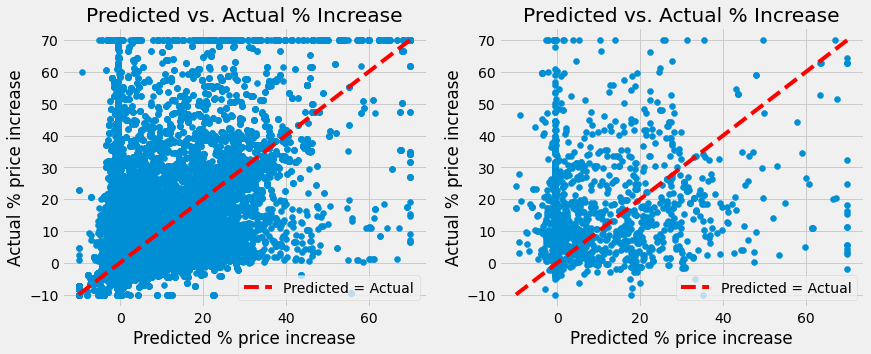

In [163]:
my_plots.plotPredictedVsActual(train_Y_preds, train_Y, cv_Y_preds, cv_Y)

### Here, we've reached a bit of a standstill in the modeling process.
Recall from above that these predictions are generated with UNDERESTIMATE_BIAS=1 -- there is no bias towards underestimates in our objective function! Yet all but 3 cross-validation estimates are well under 2%, and all but 3 estimates are in the interval \[-3, 2\]%.

This is puzzling, and I need to think more about why this would be. These predictions are kind of useless -- using them to create an investment strategy probably wouldn't result in us losing money, but we also likely wouldn't gain much, especially relative to the S&P500 gaining 8% in this time period!

However, the XGBoost model seems to be working better, so let's implement a strategy with that model in strategy_simulation.